In [175]:
import ast
from bs4 import BeautifulSoup
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import requests
from scipy import stats
import seaborn as sns
import sqlite3
from sqlite3 import Error
import time
import warnings
warnings.filterwarnings("ignore")

In [176]:
# Loading moisturizers data set
moisturizers_df = pd.read_excel("/Users/florencialeoni/code/i_feel_pretty/data/moisturizers.xls")

In [177]:
# Loading treatments data set
treatments_df = pd.read_excel("/Users/florencialeoni/code/i_feel_pretty/data/treatments.xls")

In [178]:
# Loading wellness data set
wellness_df = pd.read_excel("/Users/florencialeoni/code/i_feel_pretty/data/wellness.xls")

In [179]:
# Loading eyecare data set
eyecare_df = pd.read_excel("/Users/florencialeoni/code/i_feel_pretty/data/eyecare.xls")

In [180]:
# List of DataFrames to concat
skincare = [moisturizers_df, treatments_df, wellness_df, eyecare_df]

In [181]:
# Concat all individual data sets
skincare_df = pd.concat(skincare)

In [182]:
# Reset Index of skincare_df
skincare_df = skincare_df.reset_index(drop=True)

In [183]:
# Replace None values with np.nan
skincare_df["size"] = skincare_df["size"].replace("None", np.nan)
# Lambda function to split and strip the size column
f = lambda x: str(x).split()[0].strip() if x != np.nan else np.nan
# Lambda function to convert objects in size column to floats
g = lambda x: float(x) if x != np.nan else np.nan

In [184]:
# Clean the size column applying the lambda function through map
skincare_df["size"] = skincare_df["size"].map(f)
# Convert size column to floats through map(g)
skincare_df["size"] = skincare_df["size"].map(g)
# Convert price column to floats through map (g)
skincare_df["price"] = skincare_df["price"].map(g)

In [185]:
# Sanity Check
skincare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 9 columns):
brand            1785 non-null object
name             1785 non-null object
price            1785 non-null float64
n_of_reviews     1785 non-null int64
n_of_loves       1785 non-null int64
review_score     1785 non-null float64
size             1531 non-null float64
clean_product    1785 non-null int64
category         1785 non-null object
dtypes: float64(3), int64(3), object(3)
memory usage: 125.6+ KB


In [186]:
# Get dummy variables for categories
skincare_df = pd.get_dummies(skincare_df, columns = ["category"])

In [187]:
# Raplace spaces with undersocre in new dummy variables
skincare_df.columns = skincare_df.columns.str.replace(' ', '_')
# Drop duplicate column
skincare_df = skincare_df.drop(["category_Face_oils"], axis=1)

In [188]:
skincare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 43 columns):
brand                                 1785 non-null object
name                                  1785 non-null object
price                                 1785 non-null float64
n_of_reviews                          1785 non-null int64
n_of_loves                            1785 non-null int64
review_score                          1785 non-null float64
size                                  1531 non-null float64
clean_product                         1785 non-null int64
category_Anti-Aging                   1785 non-null uint8
category_BB_&_CC_Cream                1785 non-null uint8
category_Bath_&_Shower                1785 non-null uint8
category_Beauty_Supplements           1785 non-null uint8
category_Blemish_&_Acne_Treatments    1785 non-null uint8
category_Blotting_Papers              1785 non-null uint8
category_Body_Lotions_&_Body_Oils     1785 non-null uint8
category_Cellul

In [189]:
# Engineered feature 1: Ratio of reviews to loves (as percentage)
skincare_df["reviews_to_loves_ratio"] = round((skincare_df["n_of_reviews"] / skincare_df["n_of_loves"]) * 100, 2)

In [190]:
# Engineered feature 2: Return on reviews (as percentage)
skincare_df["return_on_reviews"] = round((skincare_df["review_score"] / skincare_df["n_of_reviews"]) * 100, 2)

In [191]:
# Engineered feature 3: Price per ounce of product
skincare_df["price_per_ounce"] = round((skincare_df["price"] / skincare_df["size"]) * 100, 2)

In [192]:
# Get indexes for rows where Number of Reviews are 0
index_numbers = skincare_df[skincare_df["n_of_reviews"] == 0 ].index
# Delete these row indexes from dataFrame
skincare_df.drop(index_numbers, inplace=True)
# Get indexes for rows where Number of Loves are 0
index_numbers_2 = skincare_df[skincare_df["n_of_loves"] == 0 ].index
# Delete these row indexes from dataFrame
skincare_df.drop(index_numbers_2, inplace=True)

In [193]:
skincare_df = skincare_df.replace([np.inf, -np.inf], np.nan)

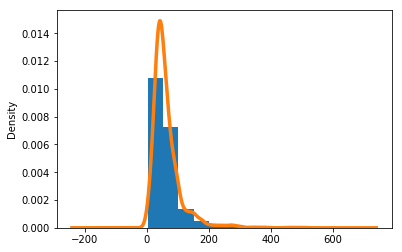

In [194]:
# Plot a histogram with a density plot for each variable in skincare_df
skincare_df["price"].plot.hist(normed = True)
skincare_df["price"].plot.kde(linewidth = 3.5)
plt.show()

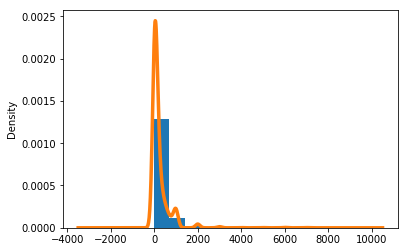

In [195]:
skincare_df["n_of_reviews"].plot.hist(normed = True)
skincare_df["n_of_reviews"].plot.kde(linewidth = 3.5)
plt.show()

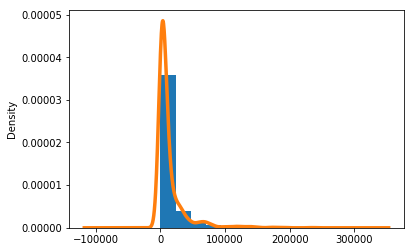

In [196]:
skincare_df["n_of_loves"].plot.hist(normed = True)
skincare_df["n_of_loves"].plot.kde(linewidth = 3.5)
plt.show()

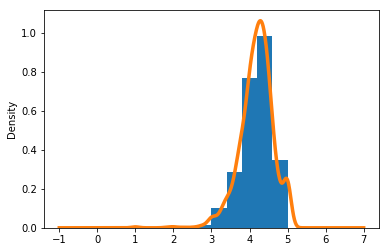

In [197]:
skincare_df["review_score"].plot.hist(normed = True)
skincare_df["review_score"].plot.kde(linewidth = 3.5)
plt.show()

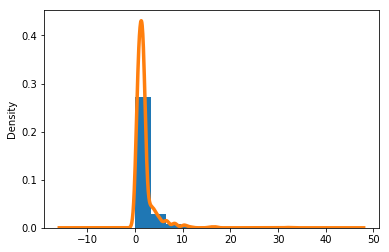

In [198]:
skincare_df["size"].plot.hist(normed = True)
skincare_df["size"].plot.kde(linewidth = 3.5)
plt.show()

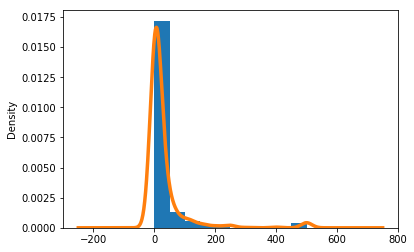

In [199]:
skincare_df["return_on_reviews"].plot.hist(normed = True)
skincare_df["return_on_reviews"].plot.kde(linewidth = 3.5)
plt.show()

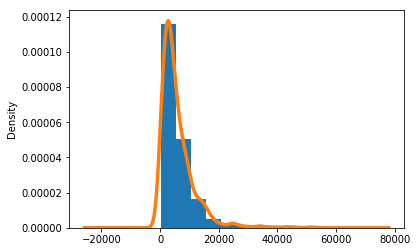

In [209]:
skincare_df["price_per_ounce"].plot.hist(normed = True)
skincare_df["price_per_ounce"].plot.kde(linewidth = 3.5)
plt.show()

In [200]:
# Create a new DF with only numbers
pretty_numbers = skincare_df.drop(["brand", "name"], axis=1).copy()

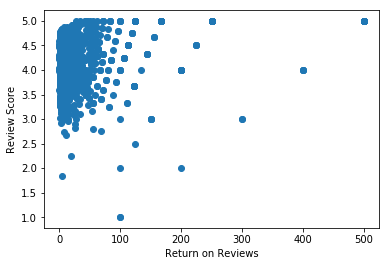

In [201]:
# Scatter plots for engineered variables!
plt.scatter(pretty_numbers.return_on_reviews,pretty_numbers.review_score)
plt.xlabel("Return on Reviews")
plt.ylabel("Review Score")
plt.show()

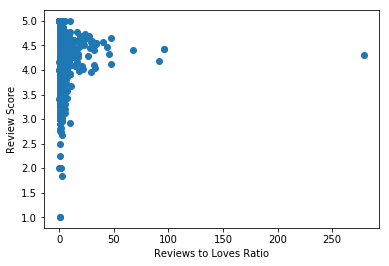

In [202]:
# Scatter plots for engineered variables!
plt.scatter(pretty_numbers.reviews_to_loves_ratio,pretty_numbers.review_score)
plt.xlabel("Reviews to Loves Ratio")
plt.ylabel("Review Score")
plt.show()

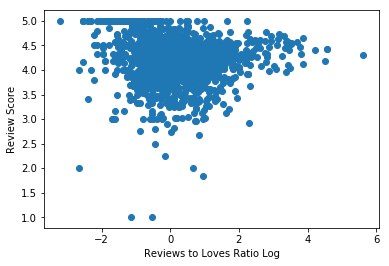

In [203]:
# Logarithmic Transformation
pretty_numbers["reviews_to_loves_log"] = round(np.log(pretty_numbers["reviews_to_loves_ratio"]), 2) 
plt.scatter(pretty_numbers.reviews_to_loves_log,pretty_numbers.review_score)
plt.xlabel("Reviews to Loves Ratio Log")
plt.ylabel("Review Score")
plt.show()

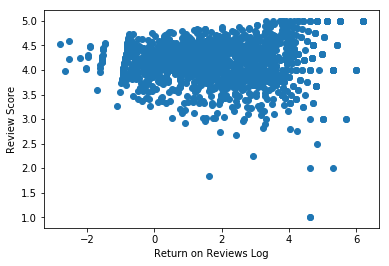

In [204]:
# Logarithmic Transformation
pretty_numbers["return_on_reviews_log"] = round(np.log(pretty_numbers["return_on_reviews"]), 2) 
plt.scatter(pretty_numbers.return_on_reviews_log,pretty_numbers.review_score)
plt.xlabel("Return on Reviews Log")
plt.ylabel("Review Score")
plt.show()

In [210]:
# Create DataFrame for Pair plot
pretty_regression = pretty_numbers[["price", "n_of_reviews", "n_of_loves", "review_score", 
                                    "size", "clean_product", "return_on_reviews", 
                                    "reviews_to_loves_ratio", "price_per_ounce"]].copy()

In [211]:
pretty_regression.head(50)

,price,n_of_reviews,n_of_loves,review_score,size,clean_product,return_on_reviews,reviews_to_loves_ratio,price_per_ounce
0,68.0,1000,136008,4.2097,1.69,1,0.42,0.74,4023.67
1,175.0,493,61648,4.0974,1.00,0,0.83,0.80,17500.00
2,39.0,2000,188389,4.0403,1.08,0,0.20,1.06,3611.11
3,68.0,1000,149323,4.2447,1.70,1,0.42,0.67,4000.00
4,179.0,788,68880,4.0622,NaN,0,0.52,1.14,NaN
5,60.0,1000,103949,4.2228,1.69,1,0.42,0.96,3550.30
6,68.0,222,31907,4.3694,1.70,1,1.97,0.70,4000.00
7,72.0,1000,117305,4.4188,1.00,1,0.44,0.85,7200.00
8,6.8,501,84567,4.1896,1.00,0,0.84,0.59,680.00
9,30.0,756,60343,4.3915,1.70,0,0.58,1.25,1764.71


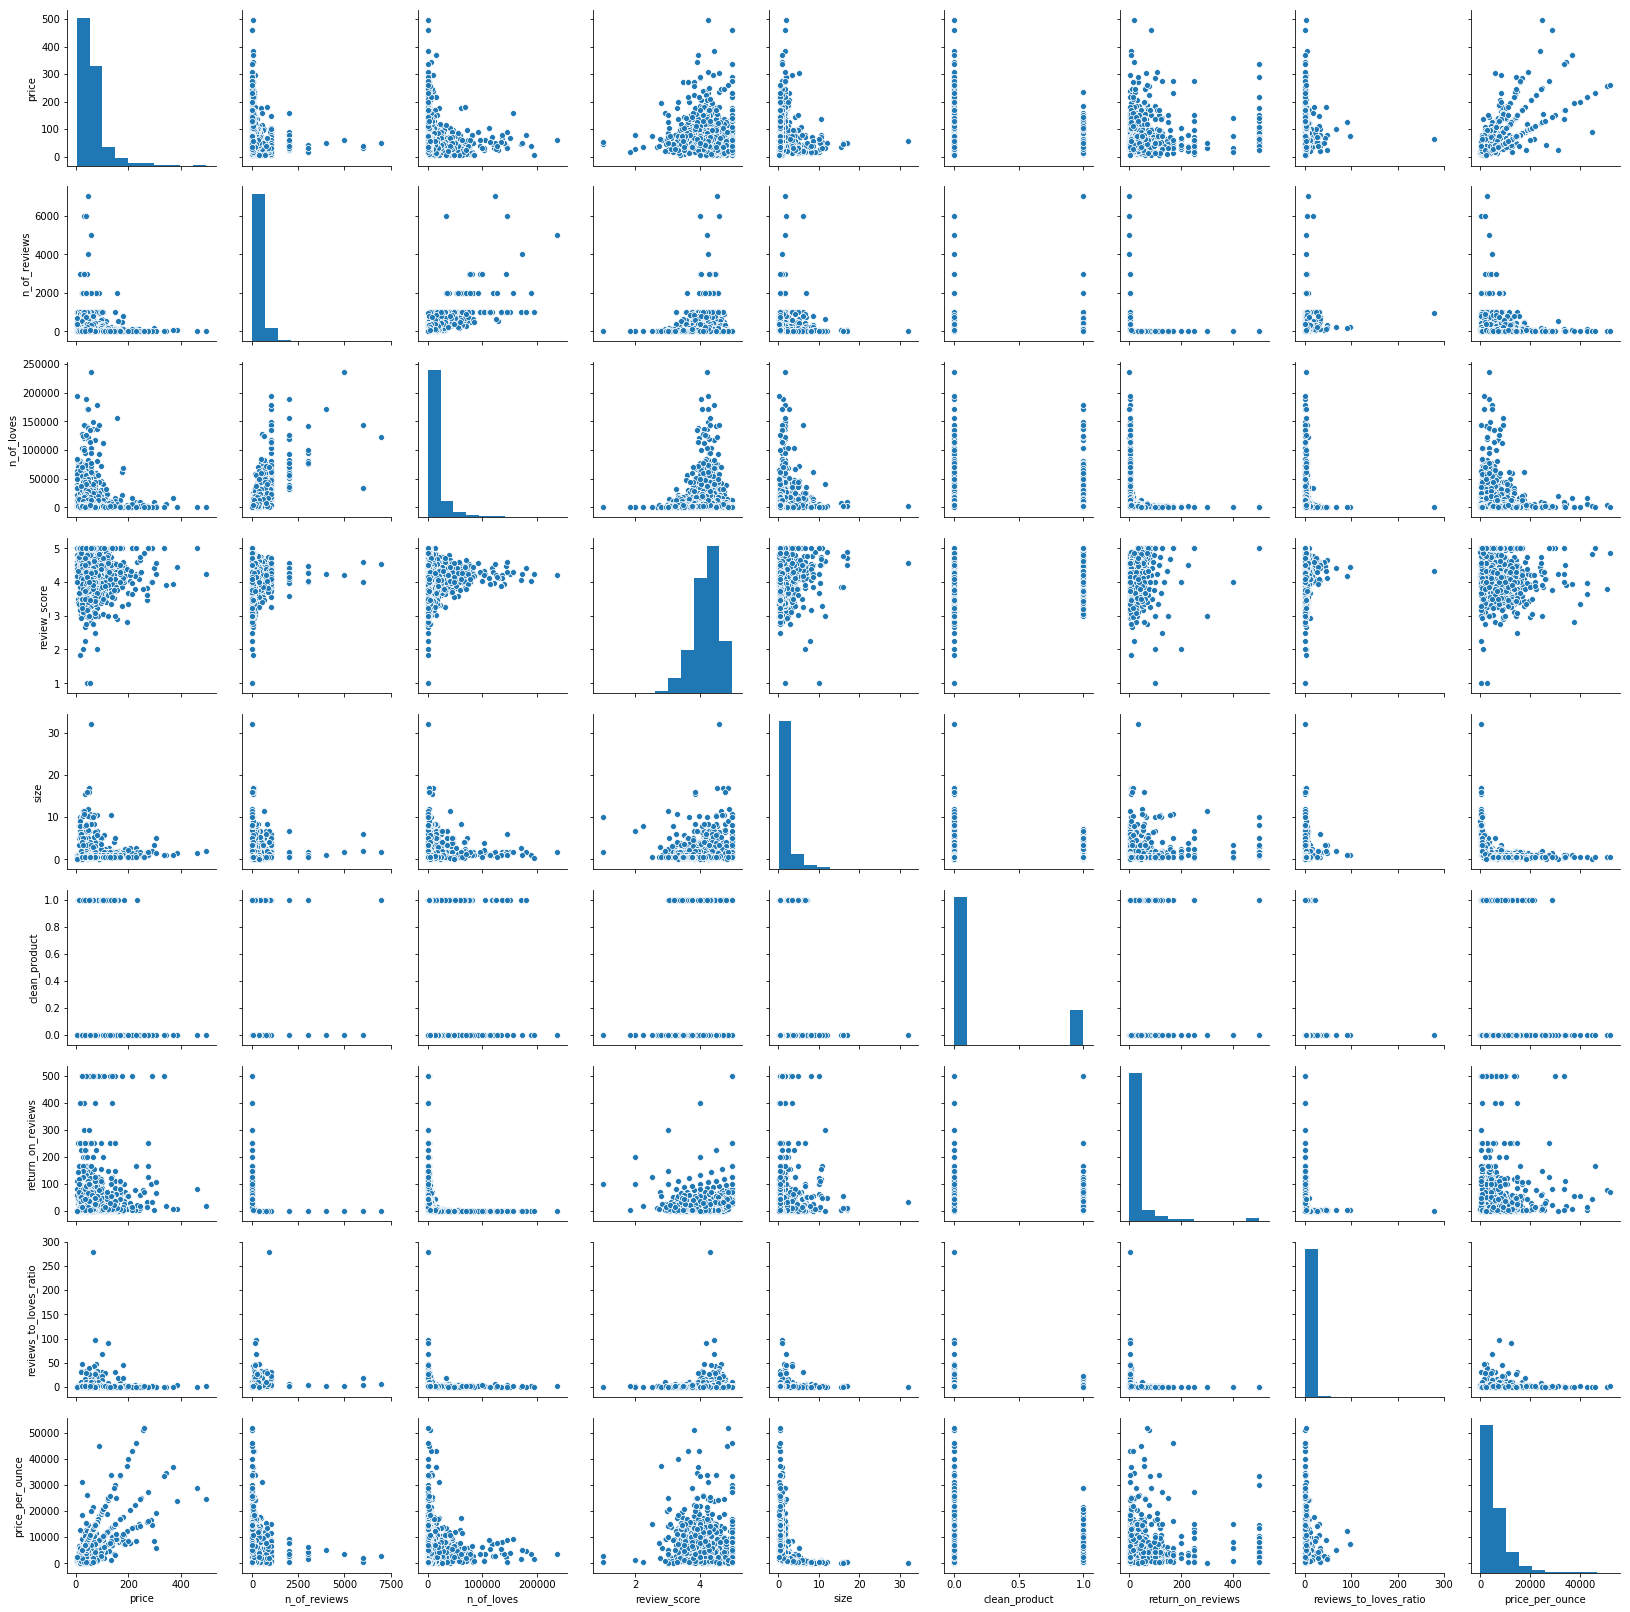

In [214]:
# Use a pairplot visualization to understand the relationships between
# all the variables in the dataset
sns.pairplot(pretty_regression)
plt.show()

In [215]:
skincare_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1784
Data columns (total 46 columns):
brand                                 1689 non-null object
name                                  1689 non-null object
price                                 1689 non-null float64
n_of_reviews                          1689 non-null int64
n_of_loves                            1689 non-null int64
review_score                          1689 non-null float64
size                                  1463 non-null float64
clean_product                         1689 non-null int64
category_Anti-Aging                   1689 non-null int64
category_BB_&_CC_Cream                1689 non-null int64
category_Bath_&_Shower                1689 non-null int64
category_Beauty_Supplements           1689 non-null int64
category_Blemish_&_Acne_Treatments    1689 non-null int64
category_Blotting_Papers              1689 non-null int64
category_Body_Lotions_&_Body_Oils     1689 non-null int64
category_Cellul

In [216]:
pretty_numbers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1784
Data columns (total 46 columns):
price                                 1689 non-null float64
n_of_reviews                          1689 non-null int64
n_of_loves                            1689 non-null int64
review_score                          1689 non-null float64
size                                  1463 non-null float64
clean_product                         1689 non-null int64
category_Anti-Aging                   1689 non-null int64
category_BB_&_CC_Cream                1689 non-null int64
category_Bath_&_Shower                1689 non-null int64
category_Beauty_Supplements           1689 non-null int64
category_Blemish_&_Acne_Treatments    1689 non-null int64
category_Blotting_Papers              1689 non-null int64
category_Body_Lotions_&_Body_Oils     1689 non-null int64
category_Cellulite_&_Stretch_Marks    1689 non-null int64
category_Decollete_&_Neck_Creams      1689 non-null int64
category_Exfoliat

In [217]:
pretty_regression.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1784
Data columns (total 9 columns):
price                     1689 non-null float64
n_of_reviews              1689 non-null int64
n_of_loves                1689 non-null int64
review_score              1689 non-null float64
size                      1463 non-null float64
clean_product             1689 non-null int64
return_on_reviews         1689 non-null float64
reviews_to_loves_ratio    1689 non-null float64
price_per_ounce           1463 non-null float64
dtypes: float64(6), int64(3)
memory usage: 212.0 KB


In [222]:
# Function to create a new SQLite3 Database
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        conn.close()

In [223]:
# Use create_connection function to create Database
create_connection("/Users/florencialeoni/code/i_feel_pretty/sephora_products.db")

In [224]:
# Create a connection object using the connect function 
# To establish a connection with "sephora.db"
connection = sqlite3.connect("sephora_products.db")
# Create a cursor object by calling the cursor method
cursor = connection.cursor()

In [225]:
# Create SQL table for the skincare DataFrame
skincare_df.to_sql("skincare", con = connection)
# Create SQL table for pretty_numbers DataFrames
pretty_numbers.to_sql("pretty_numbers", con = connection)
#Create SQL table for pretty_regression DataFrame
pretty_regression.to_sql("pretty_regression", con = connection)